# Embedding to non-Euclidean spaces

By default UMAP embeds data into Euclidean space. For 2D visualization that means that data is embedded into a 2D plane suitable for a scatterplot. In practice, however, there aren't really any major constraints that prevent the algorithm from working with other more interesting embedding spaces. In this tutorial we'll look at how to get UMAP to embed into other spaces, how to embed into your own custom space, and why this sort of approach might be useful.

To start we'll load the usual selection of libraries. In this case we will not be using the ``umap.plot`` functionality, but working with matplotlib directly since we'll be generating some custom visualizations for some of the more unique embedding spaces.

In [1]:
import numpy as np
import numba
import sklearn.datasets
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import umap
%matplotlib inline

In [2]:
sns.set(style='white', rc={'figure.figsize':(10,10)})

As a test dataset we'll use the PenDigits dataset from sklearn -- embedding into exotic spaces can be considerably more computationally taxing, so a simple relatively small dataset is going to be useful.

In [3]:
digits = sklearn.datasets.load_digits()

## Plane embeddings

Plain old plane embeddings are simple enough -- it is the default for UMAP. Here we'll run through the example again, just to ensure you are familiar with how this works, and what the result of a UMAP embedding of the PenDigits dataset looks like in the simple case of embedding in the plane.

In [4]:
plane_mapper = umap.UMAP(random_state=42).fit(digits.data)

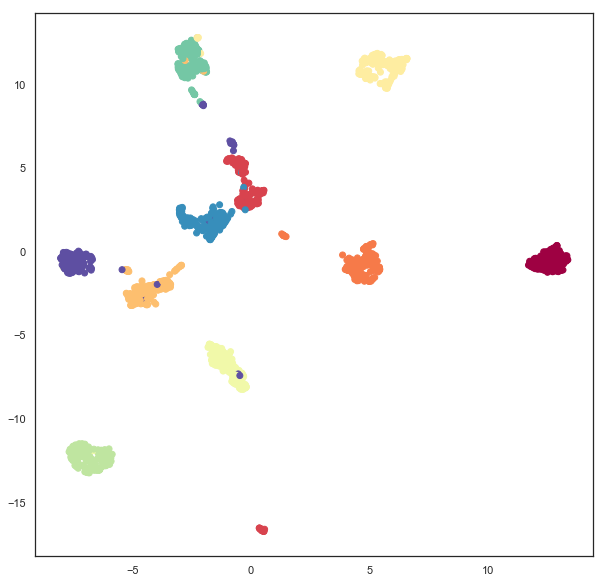

In [5]:
plt.scatter(plane_mapper.embedding_.T[0], plane_mapper.embedding_.T[1], c=digits.target, cmap='Spectral')

## Spherical embeddings

What if we wanted to embed data onto a sphere rather than a plane? This might make sense, for example, if we have reason to expect some sort of periodic behaviour or other reasons to expect that no point can be infinitely far from any other. To make UMAP embed onto a sphere we need to make use of the ``output_metric`` parameter, which specifies what metric to use for the **output** space. By default UMAP uses a Euclidean ``output_metric`` (and even has a special faster code-path for this case), but you can pass in other metrics. Among the metrics UMAP supports is the Haversine metric, used for measuring distances on a sphere, given in latitude and longitude (in radians). If we set the ``output_metric`` to ``"haversine"`` then UMAP will use that to measure distance in the embedding space.

In [6]:
sphere_mapper = umap.UMAP(output_metric='haversine', random_state=42).fit(digits.data) 

The result is the pendigits data embedded with respect to haversine distance on a sphere. The catch is that if we visualize this naively then we will get nonsense. 

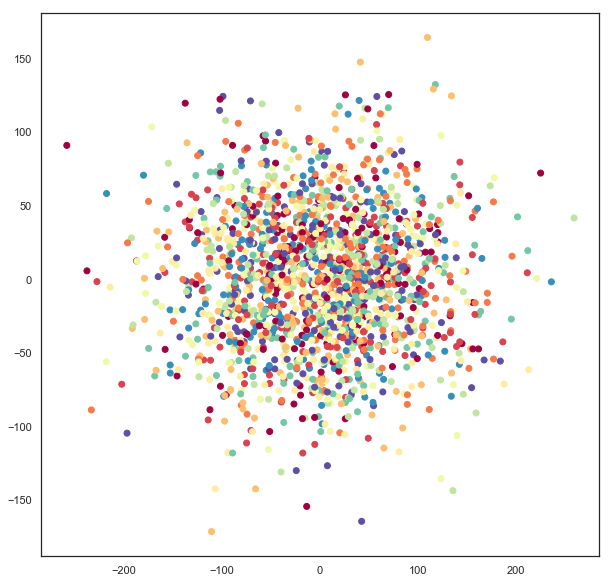

In [7]:
plt.scatter(sphere_mapper.embedding_.T[0], sphere_mapper.embedding_.T[1], c=digits.target, cmap='Spectral')

What has gone astray is that under the embedding distance metric a point at $(0, \pi)$ is distance zero from a point at $(0, 3\pi)$ since that will wrap all the way around the equator. You'll note that the scales on the x and y axes of the above plot go well outside the ranges $(-\pi, \pi)$ and $(0, 2\pi)$, so this isn't the right representation of the data. We can, however, use straightforward formulas to map this data onto a sphere embedded in 3-space.

In [8]:
x = np.sin(sphere_mapper.embedding_[:, 0]) * np.cos(sphere_mapper.embedding_[:, 1])
y = np.sin(sphere_mapper.embedding_[:, 0]) * np.sin(sphere_mapper.embedding_[:, 1])
z = np.cos(sphere_mapper.embedding_[:, 0])

Now ``x``, ``y``, and ``z`` give 3d coordinates for each embedding point that lie on the surface of a sphere. We can visualize this using matplotlib's 3d plotting capabilities, and see that we have in fact induced a quite reasonable embedding of the data onto the surface of a sphere.  

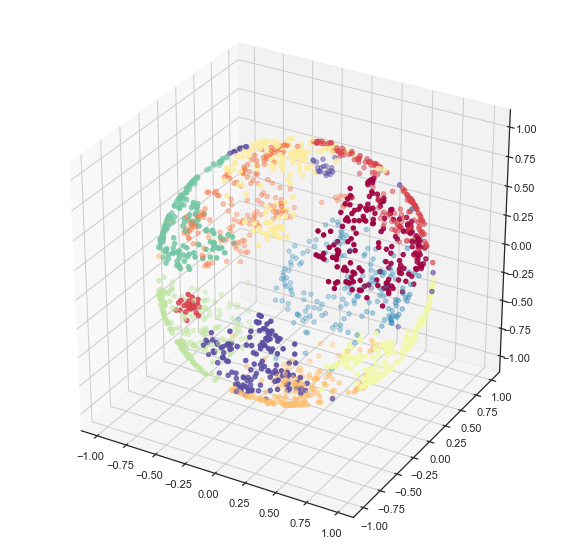

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=digits.target, cmap='Spectral')

If you prefer a 2d plot we can convert these into lat/long coordinates in the appropriate ranges and get the equivalent of a map projection of the sphere data.

In [10]:
x = np.arctan2(x, y)
y = -np.arccos(z)

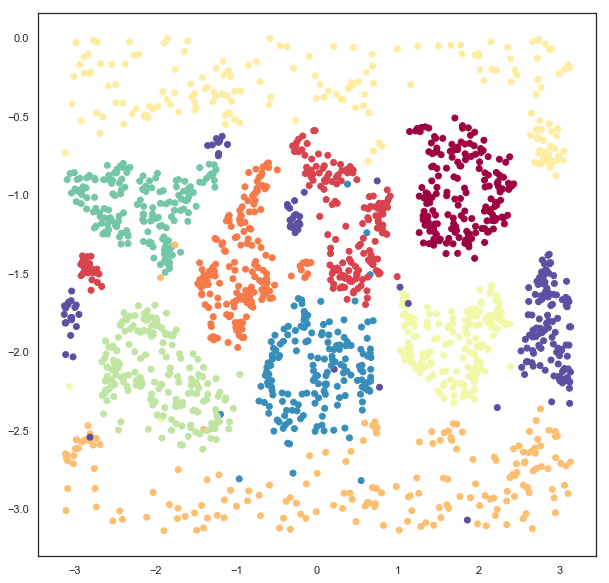

In [11]:
plt.scatter(x, y, c=digits.target.astype(np.int32), cmap='Spectral')

## Embedding on a Custom Metric Space

What if you have some other custom notion of a metric space that you would like to embed data into? In the same way that UMAP can support custom written distance metrics for the input data (as long as they can be compiled with numba), the ``output_metric`` parameter can accept custom distance functions. One catch is that, to support gradient descent optimization, the distance function needs to return both the distance, and a vector for the gradient of the distance. This latter point may require a little bit of calculus on the users part. A second catch is that it is highly beneficial to parameterize the embedding space in a way that has no coordinate constraints -- otherwise the gradient descent may step a point outside the embedding space, resulting in bad things happening. This is why, for example, the sphere example simply has points wrap around rather than constraining coordinates to be in the appropriate ranges.

Let's work through an example where we construct a distance metric and gradient for a different sort of space: a [torus](https://en.wikipedia.org/wiki/Torus). A torus is essentially just the outer surface of a donut. We can parameterize the torus in terms of x, y coordinates with the caveat that we can ["wrap around" (similar to the sphere)](https://en.wikipedia.org/wiki/Torus#Flat_torus). In such a model distances are mostly just euclidean distances, we just have to check for which is the shorter direction -- across or wrapping around -- and ensure we account for the equivalence of wrapping around several times. We can write a simple function to calculate that.

In [12]:
@numba.njit(fastmath=True)
def torus_euclidean_grad(x, y, torus_dimensions=(2*np.pi,2*np.pi)):
    """Standard euclidean distance.

    ..math::
        D(x, y) = \sqrt{\sum_i (x_i - y_i)^2}
    """
    distance_sqr = 0.0
    g = np.zeros_like(x)
    for i in range(x.shape[0]):
        a = abs(x[i] - y[i])
        if 2*a < torus_dimensions[i]:
            distance_sqr += a ** 2
            g[i] = (x[i] - y[i])
        else:
            distance_sqr += (torus_dimensions[i]-a) ** 2
            g[i] = (x[i] - y[i]) * (a - torus_dimensions[i]) / a
    distance = np.sqrt(distance_sqr)
    return distance, g/(1e-6 + distance)

Note that the gradient just derives from the standard euclidean gradient, we just have to check the direction according to the way we've wrapped around to compute the distance. We can now plug that function directly in to the ``output_metric`` parameter and end up embedding data on a torus.

In [13]:
torus_mapper = umap.UMAP(output_metric=torus_euclidean_grad, random_state=42).fit(digits.data) 

As with the sphere case, a naive visualisation will look strange, due the the wrapping around and equivalence of looping several times. But, also just like the torus, we can construct a suitable visualization by computing the 3d  coordinates for the points using a little bit of straightforward geometry (yes, I still had to look it up to check).

In [14]:
R = 3 # Size of the doughnut circle
r = 1 # Size of the doughnut cross-section

x = (R + r * np.cos(torus_mapper.embedding_[:, 0])) * np.cos(torus_mapper.embedding_[:, 1])
y = (R + r * np.cos(torus_mapper.embedding_[:, 0])) * np.sin(torus_mapper.embedding_[:, 1])
z = r * np.sin(torus_mapper.embedding_[:, 0])

Now we can visualize the result using matplotlib and see that, indeed, the data has been suitably embedded onto a torus.

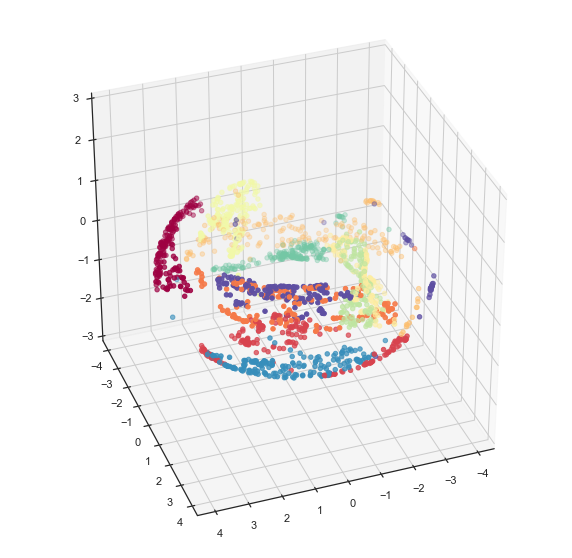

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=digits.target, cmap='Spectral')
ax.set_zlim3d(-3, 3)
ax.view_init(35, 70)

And as with the torus we can do a little geometry and unwrap the torus into a flat plane with the appropriate bounds.

In [16]:
u = np.arctan2(x,y)
v = np.arctan2(np.sqrt(x**2 + y**2) - R, z)

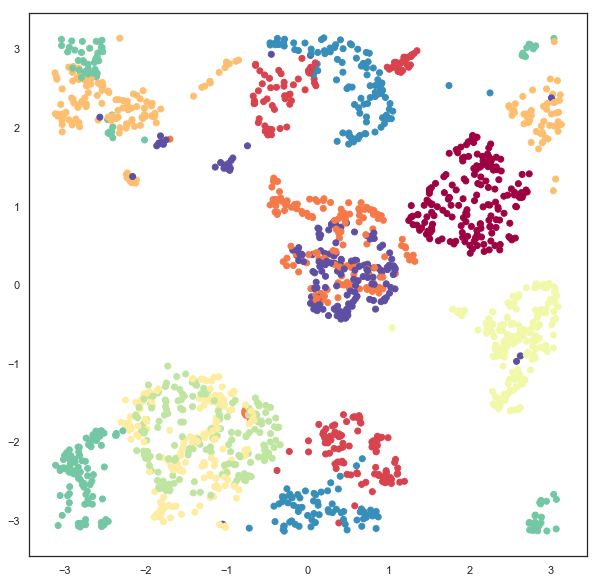

In [17]:
plt.scatter(u, v, c=digits.target, cmap='Spectral')

## A Practical Example

While the examples given so far may have some use (because some data does have suitable periodic or looping  structures that we expect will be better represented in a sphere or a torus), most data doesn't really fall in the realm of something that a user can, apriori, expect to lie on an exotic manifold. Are there more practical uses for the ability to embed in other spaces? It turns out that there are. One interesting example to consider is the space formed by 2d-Gaussian distributions. We can measure the distance between two Gaussians (parameterized by a 2d vector for the mean, and 2x2 matrix giving the covariance) by the negative log of the inner product between the PDFs (since this has a nice closed form solution, and is reasonably computable). That gives us a metric space to embed into where samples are represented not as points in 2d, but as Gaussian distributions in 2d, encoding some uncertainty in how each sample in the high dimensional space is to be embedded.

Of course we still have the issues of parameterizations that are suitable for SGD -- requiring that the covariance matrix be symmetric and positive definite is challenging. Instead we can parameterize the covariance in terms of a width, height and angle, and recover the covariance matrix from these if required. That gives us a total of 5 components to embed into (two for the mean, 3 for parameters describing the covariance). We can simply do this since the appropriate metric is defined already. Note that we have to specifically pass ``n_components=5`` since we need to explicitly embed into a 5 dimensional space to support all the covariance parameters associated to 2d Gaussians.

In [18]:
gaussian_mapper = umap.UMAP(output_metric='gaussian_energy', 
                            n_components=5,
                            random_state=42).fit(digits.data)

Since we have embedded the data into a 5 dimensional space visualization is not as trivial as it was earlier. We can get a start on visualizing the results by looking at just the means, which are the 2d locations of the modes of the Gaussians. A traditional scatter plot will suffice for this.

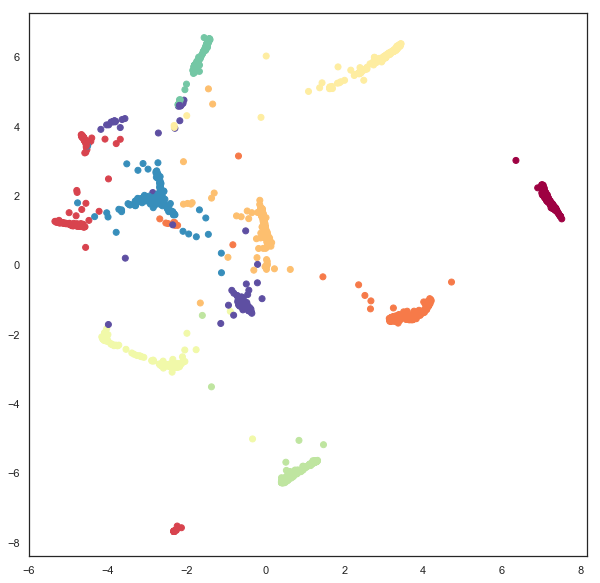

In [19]:
plt.scatter(gaussian_mapper.embedding_.T[0], gaussian_mapper.embedding_.T[1], c=digits.target, cmap='Spectral')

We see that we have gotten a result similar to a standard embedding into euclidean space, but with less clear clustering, and more points between clusters. To get a clearer idea of what is going on it will be necessary to devise a means to display some of the extra information contained in the extra 3 dimensions providing covariance data. To do this it will be helpful to be able to draw ellipses corresponding to super-level sets of the PDF of the 2d Gaussian. We can start on this by writing a simple function to draw ellipses on a plot accoriding to a position, a with, a height, and and angle (since this is the format the embedding computed the data).

In [20]:
from matplotlib.patches import Ellipse

def draw_simple_ellipse(position, width, height, angle, 
                        ax=None, from_size=0.1, to_size=0.5, n_ellipses=3,
                        alpha=0.1, color=None, 
                        **kwargs):
    ax = ax or plt.gca()
    angle = (angle / np.pi) * 180
    width, height = np.sqrt(width), np.sqrt(height)
    # Draw the Ellipse
    for nsig in np.linspace(from_size, to_size, n_ellipses):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, alpha=alpha, lw=0, color=color, **kwargs))

Now we can plot the data by providing a scatterplot of the centers (as before), but overlaying that over a super-level-set ellipses of the associated Gaussians. The obvious catch is that this will induce a lot of over-plotting, but it will at least provide a way to start understanding the embedding we have produced.

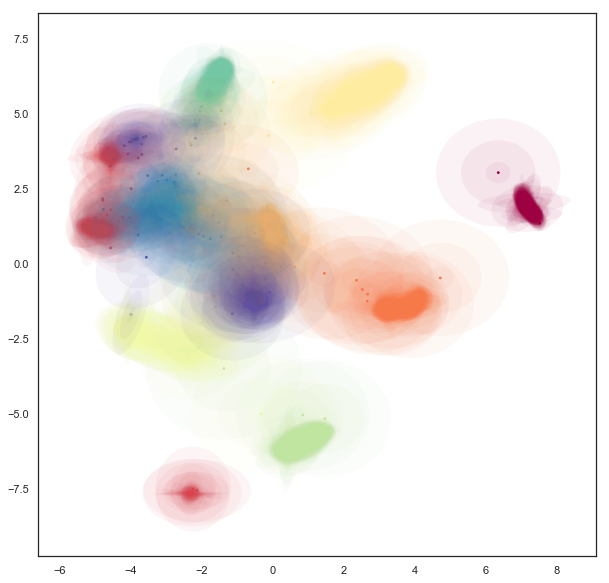

In [21]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
colors = plt.get_cmap('Spectral')(np.linspace(0, 1, 10))
for i in range(gaussian_mapper.embedding_.shape[0]):
    pos = gaussian_mapper.embedding_[i, :2]
    draw_simple_ellipse(pos, gaussian_mapper.embedding_[i, 2], 
                        gaussian_mapper.embedding_[i, 3], 
                        gaussian_mapper.embedding_[i, 4],
                        ax, color=colors[digits.target[i]], 
                        from_size=0.2, to_size=1.0, alpha=0.05)
ax.scatter(gaussian_mapper.embedding_.T[0], 
           gaussian_mapper.embedding_.T[1], 
           c=digits.target, cmap='Spectral', s=3)

Now we can see that the covariance structure for the points can vary greatly, both in absolute size, and in shape. We note that many of the points falling between clusters have much larger variances, in a sense representing the greater uncertainty of the location of the embedding. It is also worth noting that the shape of the ellipses can vary significantly -- there are several very stretched ellipses, quite distinct from many of the very round ellipses; in a sense this represents where the uncertainty falls more along a single line for example.

While this plot highlights some of the covariance structure in the outlying points, in practice the overplotting here obscures a lot of the more interesting structure in the clusters themselves. We can try to see this structure better by plotting only a single ellipse per point and using a lower alpha channel value for the ellipses, making them more translucent.

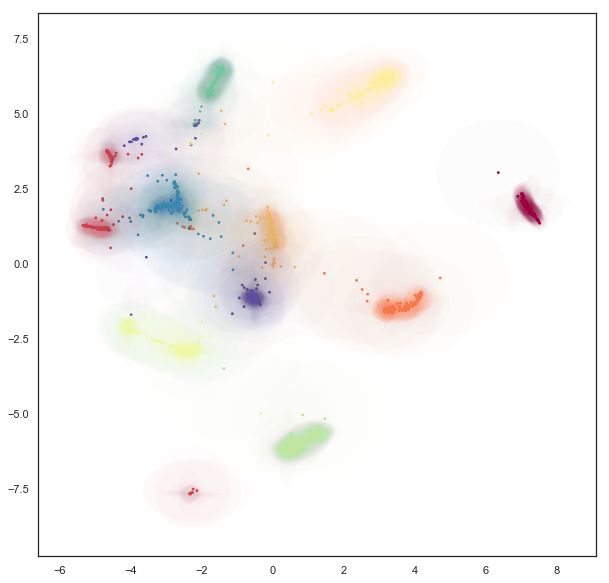

In [22]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
for i in range(gaussian_mapper.embedding_.shape[0]):
    pos = gaussian_mapper.embedding_[i, :2]
    draw_simple_ellipse(pos, gaussian_mapper.embedding_[i, 2], 
                        gaussian_mapper.embedding_[i, 3], 
                        gaussian_mapper.embedding_[i, 4],
                        ax, n_ellipses=1,
                        color=colors[digits.target[i]], 
                        from_size=1.0, to_size=1.0, alpha=0.01)
ax.scatter(gaussian_mapper.embedding_.T[0], 
           gaussian_mapper.embedding_.T[1], 
           c=digits.target, cmap='Spectral', s=3)

This lets us see the variation of density of clusters with respect to the covariance structure  -- some clusters have consistently very tight covariance,while others are more spread out (and hence have, in a sense, greater associated uncertainty. Of course we still have a degree of overplotting even here, and it will become increasingly difficult to tune alpha channels to make things visible. Instead what we would want is an actual density plot, showing the the density of the sum over all of these Gaussians.

To do this we'll need to some functions (which we'll use numba to accelerate): the evaluation of the density of a 2d Gaussian at a given point; an evaluation of the density of a given point summing over a set of several Gaussians; and a function to generate the density for each point in some grid (summing only over nearby Gaussians to make this naive approach more computable).

In [23]:
from sklearn.neighbors import KDTree

@numba.njit(fastmath=True)
def eval_gaussian(x, pos=np.array([0, 0]), cov=np.eye(2, dtype=np.float32)):
    det = cov[0,0] * cov[1,1] - cov[0,1] * cov[1,0]
    if det > 1e-16:
        cov_inv = np.array([[cov[1,1], -cov[0,1]], [-cov[1,0], cov[0,0]]]) * 1.0 / det
        diff = x - pos
        m_dist = cov_inv[0,0] * diff[0]**2 - \
            (cov_inv[0,1] + cov_inv[1,0]) * diff[0] * diff[1] + \
            cov_inv[1,1] * diff[1]**2
        return (np.exp(-0.5 * m_dist)) / (2 * np.pi * np.sqrt(np.abs(det)))
    else:
        return 0.0
    
@numba.njit(fastmath=True)
def eval_density_at_point(x, embedding):
    result = 0.0
    for i in range(embedding.shape[0]):
        pos = embedding[i, :2]
        t = embedding[i, 4]
        U = np.array([[np.cos(t), np.sin(t)], [np.sin(t), -np.cos(t)]])
        cov = U @ np.diag(embedding[i, 2:4]) @ U 
        result += eval_gaussian(x, pos=pos, cov=cov)
    return result

def create_density_plot(X, Y, embedding):
    Z = np.zeros_like(X)
    tree = KDTree(embedding[:, :2])
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            nearby_points = embedding[tree.query_radius([[X[i,j],Y[i,j]]], r=2)[0]]
            Z[i, j] = eval_density_at_point(np.array([X[i,j],Y[i,j]]), nearby_points)
    return Z / Z.sum()

Now we simply need an appropriate grid of points. We can use the plot bounds seen above, and a grid size selected for the sake of computability. The numpy ``meshgrid`` function can supply the actual grid.

In [24]:
X, Y = np.meshgrid(np.linspace(-7, 9, 300), np.linspace(-8, 8, 300))

Now we can use the function defined above to compute the density at each point in the grid, given the Gaussians produced by the embedding.

In [25]:
Z = create_density_plot(X, Y, gaussian_mapper.embedding_)

Now we can view the result as a density plot using ``imshow``. 

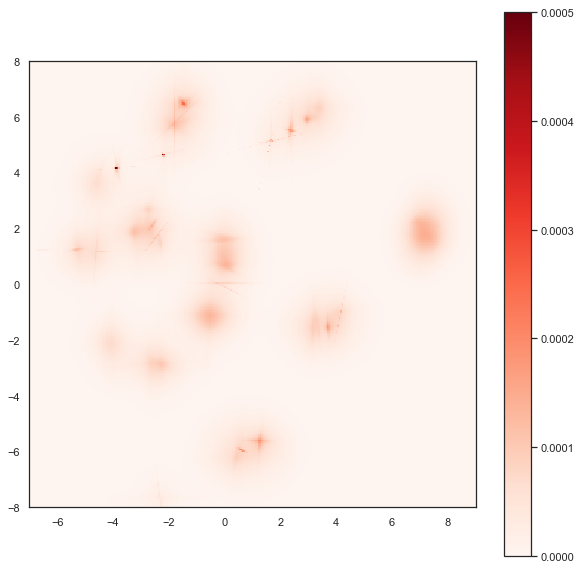

In [26]:
plt.imshow(Z, origin='lower', cmap='Reds', extent=(-7, 9, -8, 8), vmax=0.0005)
plt.colorbar()

Here we see the finer structure within the various clusters, including some of the interesting linear structures, demonstrating that this Gaussian uncertainty based embedding has captured quite detailed and useful information about the inter-relationships among the PenDigits dataset.

## Bonus: Embedding in Hyperbolic space

As a bonus example let's look at embedding data into hyperbolic space. The most popular model for this for visualization is [Poincare's disk model](https://en.wikipedia.org/wiki/Poincar%C3%A9_disk_model). An example of a regular tiling of hyperbolic space in Poincare's disk model is shown below; you may note it is similar to famous images by M.C. Escher.

<img src="Hyperbolic_tiling.png" width=400px height=400px alt="A regular tiling of the Poincare disk model of hyperbolic space" title="A regular tiling of the Poincare disk model of hyperbolic space" />

Ideally we would be able to embed directly into this Poincare disk model, but in practice this proves to be very difficult. The issue is that the disk has a "line at infinity" in a circle of radius one bounding the disk. Outside of that circle things are not well defined. As you may recall from the discussion of embedding onto spheres and toruses it is best if we can have a parameterisation of the embedding space that it is hard to move out of. The Poincare disk model is almost the opposite of this -- as soon as we move outside the unit circle we have moved off the manifold and further updates will be badly defined. We therefore instead need a different parameterisation of hyperbolic space that is less constrained. One option is the Poincare half-plane model, but this, again, has a boundary that it is easy to move beyond. The simplest option is the [hyperboloid model](https://en.wikipedia.org/wiki/Hyperboloid_model). Under this model we can simply move in x and y coordinates, and solve for the corresponding z coordinate when we need to compute distances. This model has been implemented under the distance metric ``"hyperboloid"`` so we can simply use it out-of-the-box.

In [27]:
hyperbolic_mapper = umap.UMAP(output_metric='hyperboloid', 
                              random_state=42).fit(digits.data)

A straightforward visualization option is to simply view the x and y coordinates we have arrived at:

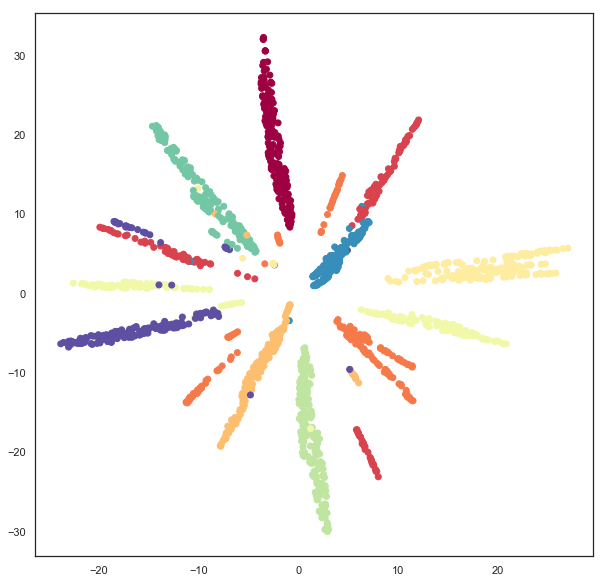

In [28]:
plt.scatter(hyperbolic_mapper.embedding_.T[0], 
            hyperbolic_mapper.embedding_.T[1], 
            c=digits.target, cmap='Spectral')

We can also solve for the z coordinate and view the data lying on a hyperboloid in 3d space.

In [29]:
x = hyperbolic_mapper.embedding_[:, 0]
y = hyperbolic_mapper.embedding_[:, 1]
z = np.sqrt(1 + np.sum(hyperbolic_mapper.embedding_**2, axis=1))

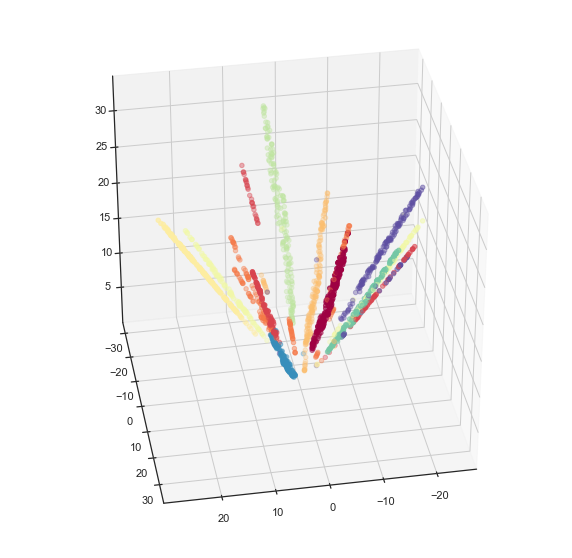

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=digits.target, cmap='Spectral')
ax.view_init(35, 80)

But we can do more -- since we have embedded the data successfully in hyperbolic space we can map the data into the Poincare disk model. This is, in fact, a straightforward computation.

In [31]:
disk_x = x / (1 + z)
disk_y = y / (1 + z)

Now we can visualize the data in a Poincare disk model embedding as we first wanted. For this we simply generate a scatterplot of the data, and then draw in the bounding circle of the line at infinity.

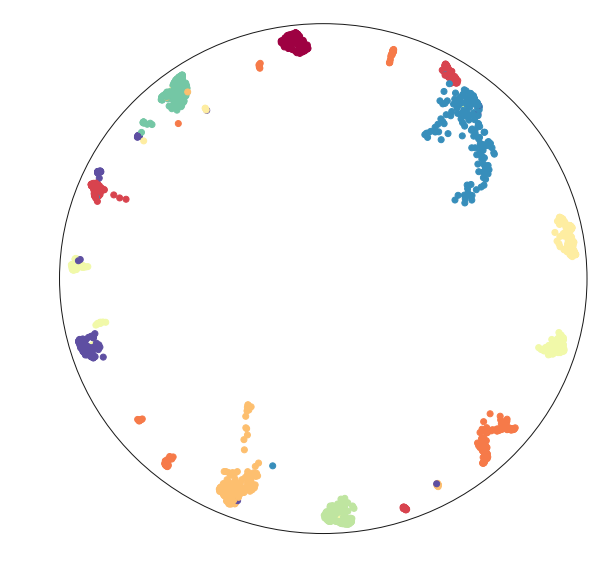

In [34]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(disk_x, disk_y, c=digits.target, cmap='Spectral')
boundary = plt.Circle((0,0), 1, fc='none', ec='k')
ax.add_artist(boundary)
ax.axis('off');

Hopefully this has provided a useful example of how to go about embedding into non-euclidean spaces. This last example ideally highlights the limitations of this approach (we really need a suitable parameterisation), and some potential approaches to get around this: we can use an alternative parameterisation for the embedding, and then transform the data into the the desired representation.